<a href="https://colab.research.google.com/github/hackerinheels/dresser/blob/main/us2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook that builds a model to identify a traditional dresser against a contemporary or industrial style dresser.

In [219]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
import pathlib
trainingdata_url = "https://storage.googleapis.com/furndata/us.zip"
testdata_url = "https://storage.googleapis.com/furndata/test.zip"
data_dir = tf.keras.utils.get_file(origin=trainingdata_url, 
                                   fname='us', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
test_data_dir = tf.keras.utils.get_file(origin=testdata_url, 
                                   fname='test', 
                                   untar=True)
test_data_dir = pathlib.Path(test_data_dir)
!unzip /root/.keras/datasets/us.tar.gz -d ./
!unzip /root/.keras/datasets/test.tar.gz -d ./

In [221]:
training_data_dir = "/content/us/"
training_data_dir = pathlib.Path(training_data_dir)
test_data_dir = "/content/test/"
test_data_dir = pathlib.Path(test_data_dir)
# First run unzip data.tar.gz
print(len(list(training_data_dir.glob('*/*'))))
print(len(list(test_data_dir.glob('*/*'))))

122
9


In [273]:
batch_size = 32
img_height = 180
img_width = 180

In [223]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_data_dir,
  validation_split=0.2,
  subset="training",
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 119 files belonging to 2 classes.
Using 96 files for training.


In [224]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_data_dir,
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 119 files belonging to 2 classes.
Using 23 files for validation.


In [274]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9 files belonging to 2 classes.


In [226]:
class_names = train_ds.class_names
print(class_names)

['aeshaan', 'me']


tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)


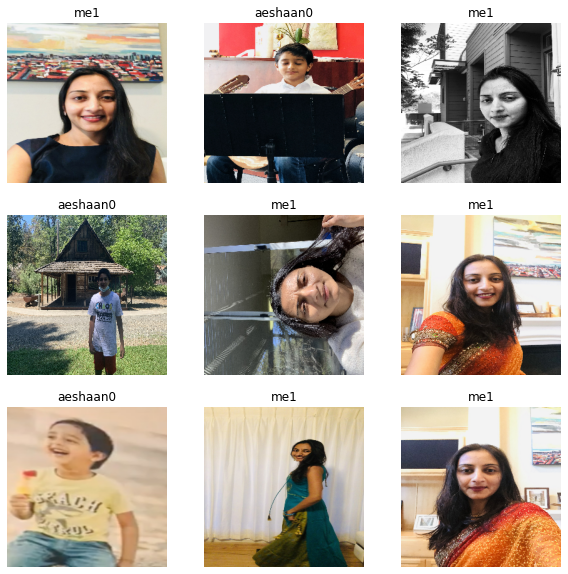

In [264]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    print(labels[i])
    plt.title(class_names[labels[i]]+ str(labels[i].numpy()))
    plt.axis("off")

In [251]:
num_classes = 2
IMG_SIZE = 180
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [252]:
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

In [265]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_15 (Resizing)       (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_15 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 41, 41, 64)      

In [254]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
3/3 [==============================] - 9s 2s/step - loss: 1.9284 - accuracy: 0.4896 - val_loss: 0.5613 - val_accuracy: 0.7391
Epoch 2/10
3/3 [==============================] - 8s 1s/step - loss: 0.7391 - accuracy: 0.4792 - val_loss: 0.6000 - val_accuracy: 0.7391
Epoch 3/10
3/3 [==============================] - 8s 1s/step - loss: 0.6931 - accuracy: 0.4792 - val_loss: 0.6500 - val_accuracy: 0.7391
Epoch 4/10
3/3 [==============================] - 8s 1s/step - loss: 0.6735 - accuracy: 0.6562 - val_loss: 0.6937 - val_accuracy: 0.3043
Epoch 5/10
3/3 [==============================] - 8s 1s/step - loss: 0.6518 - accuracy: 0.7396 - val_loss: 0.6324 - val_accuracy: 0.8696
Epoch 6/10
3/3 [==============================] - 8s 1s/step - loss: 0.6326 - accuracy: 0.8229 - val_loss: 0.6212 - val_accuracy: 0.8696
Epoch 7/10
3/3 [==============================] - 8s 1s/step - loss: 0.5932 - accuracy: 0.8125 - val_loss: 0.5631 - val_accuracy: 0.8261
Epoch 8/10
3/3 [=========================

In [280]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds)
print("test loss, test acc:", results)


Evaluate on test data
1/1 [==============================] - 1s 605ms/step - loss: 0.5770 - accuracy: 0.8889
test loss, test acc: [0.5769674777984619, 0.8888888955116272]


In [263]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_ds)
print("predictions:\n", predictions)
print(predictions.numpy())

Generate predictions for 3 samples
predictions shape:
 [[0.33990827]
 [0.37887198]
 [0.32911068]
 [0.70981073]
 [0.17920929]
 [0.50062096]
 [0.39865476]
 [0.46390024]
 [0.55312467]]


AttributeError: ignored

[[0.2424067 ]
 [0.16554761]
 [0.29650432]
 [0.452413  ]
 [0.37019014]
 [0.46886522]
 [0.514136  ]
 [0.6595812 ]
 [0.37134182]]


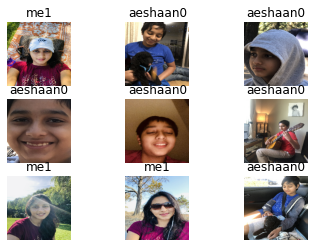

In [279]:
for images, labels in test_ds.take(1):
  predictions = model.predict(images)
  print(predictions)
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]]+ str(labels[i].numpy()))
    plt.axis("off")

In [257]:
y_true = [0,0,1,0,1,0,0,0,1]
m = tf.keras.metrics.binary_accuracy(y_true, predictions, threshold=0.5)
print("Which predictions match with binary labels:", m.numpy())

m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_true, predictions)
print("Binary Accuracy: ", m.result().numpy())


Which predictions match with binary labels: [0.6666667  0.6666667  0.6666667  0.33333334 0.6666667  0.6666667
 0.6666667  0.33333334 0.33333334]
Binary Accuracy:  0.5555556


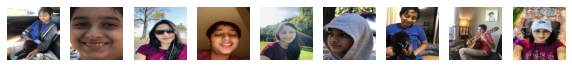

In [239]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(1, 9, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
checkpoint_path = "/content/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1,
  callbacks=[cp_callback]
)
# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

3/3 [==============================] - 18s 5s/step - loss: 2.1922 - accuracy: 0.9062 - val_loss: 20.4346 - val_accuracy: 0.2609

Epoch 00001: saving model to /content/cp.ckpt


In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
#loss, acc = model.evaluate(test_images, test_labels, verbose=2)


NOW Trying hyperparameterization automation using Keras Tuner with a diff model

In [ ]:
!pip install -q -U keras-tuner

In [ ]:

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization, experimental
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt

In [ ]:
# define cnn model
def build_model_1(hp):
	model = Sequential()
	#model.add(experimental.preprocessing.Rescaling(1./255))
	#model.add(experimental.preprocessing.Resizing(256, 256))
	hp_filters = hp.Int('filters', min_value = 32, max_value = 64, step = 32)
	model.add(Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(180,180, 3)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.1))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='softmax'))
	# compile model
	#opt = SGD(lr=0.001, momentum=0.9)
	hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3])
	opt = Adam(learning_rate=hp_learning_rate)#, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	model.summary()
	return model

In [ ]:

tuner = RandomSearch(
    build_model_1,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1)
#,
#    directory='my_dir1') #change the directory name here  when rerunning the cell else it gives "Oracle exit error" 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0

In [ ]:
!\rm -rf ./untitled_project/oracle.json

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_ds, validation_data=val_ds,
  epochs=3)

Trial 4 Complete [00h 02m 03s]
val_accuracy: 0.739130437374115

Best val_accuracy So Far: 0.739130437374115
Total elapsed time: 00h 05m 52s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()


Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters: 64
learning_rate: 0.001
Score: 0.739130437374115
Trial summary
Hyperparameters:
filters: 32
learning_rate: 0.001
Score: 0.739130437374115
Trial summary
Hyperparameters:
filters: 32
learning_rate: 0.01
Score: 0.739130437374115
Trial summary
Hyperparameters:
filters: 64
learning_rate: 0.01
Score: 0.739130437374115


A few things remaining
1. Use tuner results
2. Add TF displayboard


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
for x, y in train_ds.take(1):
  print("Shape: ", x.shape)
  print("Label: ", y[0], "->", class_names[y[0]])

Shape:  (32, 256, 256, 3)
Label:  tf.Tensor(1, shape=(), dtype=int32) -> me


In [ ]:
#Visualizing a single image
from datetime import datetime
import io
import itertools
from packaging import version

# Clear out any prior log data.
!rm -rf logs

# Sets up a timestamped log directory.
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

img = x[0]
# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", x, step=0)

In [ ]:
# Reshape the image for the Summary API.
img = np.reshape(x[0], (-1, 256, 256, 3))
with file_writer.as_default():
  tf.summary.image("Training data", img, step=0)

In [ ]:
!pip install tensorboard --ignore-installed



In [ ]:
with file_writer.as_default():
  # Don't forget to reshape.
  tf.summary.image("Test data", x, max_outputs=25, step=0)

%tensorboard --logdir logs/train_data -bind_all
